In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import concurrent

# Defining the paths

In [2]:
DATA_FOLDER = 'data/'
WIKI_FOLDER = 'wiki_crop/'
IMAGES_FOLDER = 'images/'

FACES_FOLDER = 'faces/'
CSV_FOLDER = FACES_FOLDER + 'csv/'

saving = False

# Getting the image paths and reading the images

In [3]:
def get_image_paths(folder, id=-1):
    if id == -1:
        return [folder + f for f in os.listdir(folder) if f.endswith('.jpg')]
    return [folder + id + '/' + f for f in os.listdir(folder + id + '/') if f.endswith('.jpg')]


if not os.path.exists(DATA_FOLDER + IMAGES_FOLDER):
    os.makedirs(DATA_FOLDER + IMAGES_FOLDER)

image_paths = get_image_paths(DATA_FOLDER + IMAGES_FOLDER)
if len(image_paths) > 0:
    image_paths = np.array(image_paths)
else:
    image_paths = [get_image_paths(DATA_FOLDER + WIKI_FOLDER, str(i).zfill(2)) for i in range(100)]
    image_paths = np.concatenate(image_paths)

In [4]:
def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    assert img is not None

    if img.shape[:2] == (1, 1):
        return {
            'folder': None,
            'file': None,
            'image': None
        }

    split = image_path.split('/')
    folder = split[-2]
    file = split[-1]

    return {
        'folder': folder,
        'file': file,
        'image': img
    }


images = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(read_image, image_path) for image_path in image_paths]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(image_paths)):
        if future.result()['image'] is not None:
            images.append(future.result())

images = pd.DataFrame().from_dict(images)

100%|██████████| 54258/54258 [00:19<00:00, 2800.83it/s]


In [5]:
if saving:
    for i, row in tqdm(images.iterrows(), total=len(images)):
        cv2.imwrite(DATA_FOLDER + IMAGES_FOLDER + row['file'], cv2.cvtColor(row['image'], cv2.COLOR_RGB2BGR))

In [6]:
images.sort_values(by=['folder', 'file'], inplace=True)

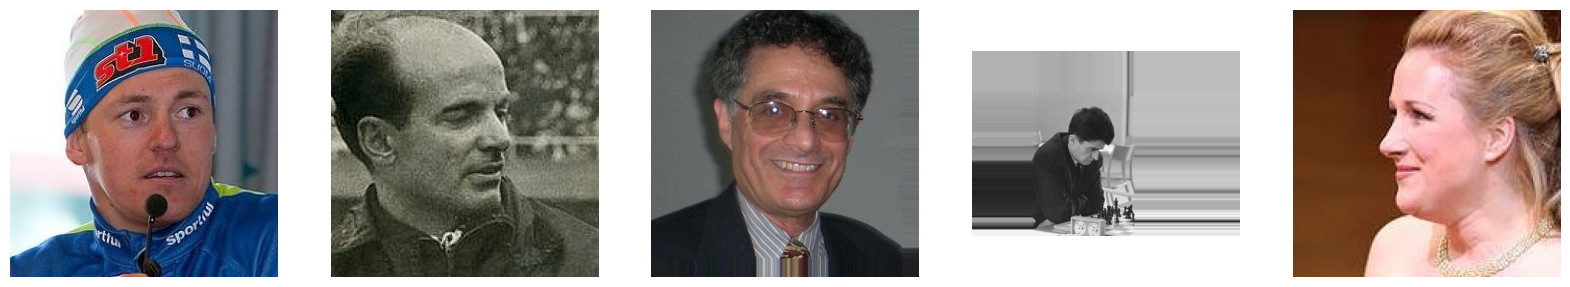

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(images.iloc[i]['image'])
    ax.axis('off')
plt.show()

# Detecting faces using the Yunet from OpenCV

In [8]:
def detect_yunet(row):
    frame_current = row['image']
    height, width, _ = frame_current.shape

    detector = cv2.FaceDetectorYN.create("face_detection_yunet_2023mar.onnx", "", (width, height))

    _, faces = detector.detect(frame_current)

    if faces is None or len(faces) > 1:
        return {
            'filename': row['file'],
            'faces': None
        }

    for face in faces:
        list_ = list(map(int, face))
        box = list_[:4]
        right_eye = list_[4:6]
        left_eye = list_[6:8]

        nose = list_[8:10]
        lips_right = list_[10:12]
        lips_left = list_[12:14]

        box_x, box_y, box_w, box_h = box

        # checking if nose is in the middle of the face +-5%
        if nose[0] < box_x + box_w * 0.45 or nose[0] > box_x + box_w * 0.55:
            return {
                'filename': row['file'],
                'faces': None
            }

        # checking if eyes are in the box
        if (right_eye[0] < box_x or right_eye[0] > box_x + box_w or
                right_eye[1] < box_y or right_eye[1] > box_y + box_h or
                left_eye[0] < box_x or left_eye[0] > box_x + box_w or
                left_eye[1] < box_y or left_eye[1] > box_y + box_h):
            return {
                'filename': row['file'],
                'faces': None
            }

        # checking if nose is between the eyes and lips
        if (nose[0] < right_eye[0] or nose[0] > left_eye[0] or
            nose[0] < lips_right[0] or nose[0] > lips_left[0]):
            return {
                'filename': row['file'],
                'faces': None
            }

        # checking if the line between the eyes is horizontal +-10 degrees
        dy = right_eye[1] - left_eye[1]
        dx = right_eye[0] - left_eye[0]
        angle = np.arctan2(dy, dx) * 180.0 / np.pi

        if abs(angle) > 5:
            return {
                'filename': row['file'],
                'faces': box,
                'left_eye': left_eye,
                'right_eye': right_eye,
                'nose': nose,
                'lips_right': lips_right,
                'lips_left': lips_left
            }

In [9]:
image_faces = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(detect_yunet, row) for _, row in images.iterrows()]
    for future in tqdm(concurrent.futures.as_completed(futures), total=images.shape[0]):
        if future.result()['faces'] is not None:
            image_faces.append(future.result())

image_faces = pd.DataFrame().from_dict(image_faces)

100%|██████████| 54258/54258 [03:44<00:00, 241.96it/s] 


In [10]:
image_faces.shape

(8642, 7)

# Saving features and images

In [16]:
margin = 0.1
suffix = f"margin_{int(margin * 100)}%"

In [17]:
if not os.path.exists(CSV_FOLDER):
    os.makedirs(CSV_FOLDER)

image_faces.to_csv(CSV_FOLDER + 'image_faces_' + suffix + '.csv', index=False)

In [18]:
cropped_faces = []

def crop_face(row):
    img = images[images['file'] == row['filename']]['image'].values[0]
    face = row['faces']

    x, y, w, h = face

    x -= int(w * margin)
    if x < 0:
        x = 0
    w += int(w * margin * 2)

    y -= int(h * margin)
    if y < 0:
        y = 0
    h += int(h * margin * 2)

    cropped = img[y:y + h, x:x + w]
    return {
        'filename': row['filename'],
        'face': cropped
    }

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(crop_face, row) for _, row in image_faces.iterrows()]
    for future in tqdm(concurrent.futures.as_completed(futures), total=image_faces.shape[0]):
        cropped_faces.append(future.result())

cropped_faces = pd.DataFrame().from_dict(cropped_faces)

100%|██████████| 8642/8642 [00:06<00:00, 1351.78it/s]


In [19]:
faces_subfolder = FACES_FOLDER + suffix + '/'

if not os.path.exists(FACES_FOLDER):
    os.makedirs(FACES_FOLDER)
    
if not os.path.exists(faces_subfolder):
    os.makedirs(faces_subfolder)

for _, face in tqdm(cropped_faces.iterrows(), total=cropped_faces.shape[0]):
    cv2.imwrite(faces_subfolder + face['filename'], cv2.cvtColor(face['face'], cv2.COLOR_RGB2BGR))

100%|██████████| 8642/8642 [00:10<00:00, 831.63it/s]
